In [2]:
%load_ext autoreload
import glob
import shutil
import nibabel
import pandas as pd
import numpy as np
import os
from IPython.core.debugger import set_trace
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from tqdm import notebook, tqdm
from joblib import Parallel, delayed

import torchio as tio
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from utils import create_dicts, load, check_patch
from multiprocessing import cpu_count
N_CPU = cpu_count()

from IPython.core.display import display, HTML
from celluloid import Camera
from itertools import product

SEED = 42
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def calculate_patches(k, 
                      paths_dict, 
                      labels_components, 
                      aug_steps, 
                      patch_size, 
                      fcd_threshold):
    
    patches = []
    path_dict = paths_dict[k]
    label_info = labels_components[k]
    center = label_info['center']
    label = nibabel.load(path_dict['label']).get_fdata()
    mask = nibabel.load(path_dict['mask']).get_fdata() > 0
    X,Y,Z = mask.shape
    pad = PATCH_SIZE//2
    n_fcd = label.sum()
    
    # get rid of a mid-brain
    X_mean = X//2
    thresh_mask = (np.arange(X) < (X_mean - pad)) | (np.arange(X) > (X_mean + pad))
    thresh_mask = np.tile(thresh_mask, (Y,Z,1)).transpose(2,0,1)
    mask = mask_tensor*(thresh_mask > 0)
    xyz_grid = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), -1)
    xyz_grid = xyz_grid[mask_tensor]
    
    for x,y,z in tqdm(xyz_grid):
        
        patch_info = check_patch(x,y,z)
        info_patch_nonfcd = patch_info
        info_patch_nonfcd['patch_center'] = np.array([x,y,z])
        info_patch_nonfcd['label'] = k
        
        patches.append(info_patch_nonfcd)
    
    return patches

In [7]:
PATCH_SIZE = 64
patches_root = f'patches_{PATCH_SIZE}/'
tensors_root = '../fcd_data/tensors_MNI152/'

In [8]:
labels = list(map(lambda x: x.split('tensor_')[1], os.listdir(tensors_root)))

In [10]:
labels_components = np.load('metadata/label_info.npy', allow_pickle=True).item()

In [ ]:
path = os.path.join(tensors_root, '')
torch.load()

In [7]:
for name in labels.keys():
    
    patch_size = 32
    patches = []
    label_info = labels_components[name]
    center = label_info['center']
    label = (nibabel.load(path_dict['label']).get_fdata() > 0).astype(int)
    mask = nibabel.load(path_dict['mask']).get_fdata() > 0
    
    X,Y,Z = mask.shape
    pad = patch_size//2
    n_fcd = label.sum()

    # get rid of a mid-brain
    # X_mean = X//2
    # thresh_mask = (np.arange(X) < (X_mean - pad)) | (np.arange(X) > (X_mean + pad))
    # thresh_mask = np.tile(thresh_mask, (Y,Z,1)).transpose(2,0,1)
    # mask = mask*(thresh_mask > 0)

    xyz_grid = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), -1)
    xyz_grid = xyz_grid[mask]

    for x,y,z in tqdm(xyz_grid):

        patch_info = check_patch(x,y,z, mask, label, pad)
        
        if patch_info is not None:

            patch_info['label'] = name
            patch_info['n_fcd'] = n_fcd

            patches.append(patch_info)


    pd.DataFrame(patches).to_csv(f'patches_dataframes/label-{name}_ps32_notrim')

In [149]:
# balance = []

# for k in tqdm(paths_dict.keys()):
#     df = pd.read_csv(f'patches/label-{k}_ps32_notrim', 
#                                         index_col=0)
          
#     df['fcd_percentage'] = df['n_label'] / df['n_fcd']
#     df['target'] = (df['fcd_percentage'] >= 0.5).astype(int)
#     drop_index = df.query(f"fcd_percentage>0 & fcd_percentage<{0.5}").index
#     df.drop(index=drop_index, inplace=True)
    
#     balance.append(df['target'].sum()/df.shape[0])
          
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [06:57<00:00,  6.63s/it]


In [168]:
# 1/(np.mean(balance))

In [298]:
df = pd.read_csv(f'patches_dataframes/label-38_ps32_notrim', 
                index_col=0)

In [171]:
symmetry = tio.RandomFlip(axes=0) 
bias = tio.RandomBiasField(coefficients=0.3)
noise = tio.RandomNoise(std=(0,1e-3))
affine = tio.RandomAffine(scales=(0.9, 1.1, 0.9, 1.1, 0.9, 1.1), 
                     degrees=5,
                     translation=(1,1,1),
                     center='image',
                     default_pad_value=0)
rescale = tio.RescaleIntensity(out_min_max=(0, 1))
augmentation = tio.Compose([symmetry, bias, noise, affine, rescale])

In [177]:
tensor_dict = torch.load('/nfs/garfield/ibulygin/tensors_v2/tensor_1')

In [185]:
features = set(tensor_dict.keys()) - {'label', 'mask'}
brain_tensor_torch = torch.stack([tensor_dict[f] for f in features], dim=0)#.unsqueeze(0)

In [186]:
brain_tensor_torch_aug = augmentation(brain_tensor_torch)

In [189]:
brain_tensor_torch_aug.min()

tensor(0.)

In [204]:
# df = pd.read_csv('foo', index_col=0, dtype={'x': int, 'y': int, 'z': int,
#                                           'p_mask':float,
#                                            'n_label':int,
#                                            'label':int,
#                                            'n_fcd':int,
#                                            'fcd_percentage':float,
#                                            'target':int})

In [299]:
df['target'] = (df['n_label'] > 0).astype(int)

In [300]:
target_ind = np.array(df.query('target==1').index.tolist())
non_target_ind = df.query('target!=1').index
non_target_ind_sample = np.random.choice(non_target_ind, size=len(target_ind), replace=False)
new_indexes = np.concatenate([target_ind,non_target_ind_sample])
new_indexes = pd.core.indexes.numeric.Int64Index(data=new_indexes)
df = df.loc[new_indexes]

In [ ]:
os.path.isfile()

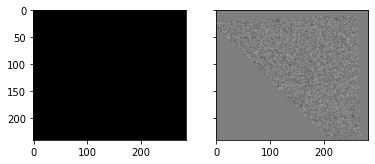

In [187]:
plt.ioff()
camera = video_comparison([brain_tensor_torch[0].numpy(), brain_tensor_torch_aug[0].numpy()],
                          n_slides=132)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [ ]:
class PatchesDataset(Dataset):

    def __init__(self, root, config, train=True):
        
        self.root = root
        self.train = train
        self.features = config.dataset.features
        self.patch_size = config.dataset.patch_size
        self.fcd_threshold = config.dataset.fcd_threshold
        
        self.patch_dataframe_path = config.dataset.patch_dataframe_path
        self.metadata = np.load(self.metadata_path, allow_pickle=True).item()
        metadata_key = 'train' if self.train else 'test'
        self.labels = self.metadata[metadata_key]
        
        self.df = pd.concat([self.process_df(pd.read_csv(f'{self.patch_dataframe_path}/label-{k}_ps{self.patch_size}_notrim', 
                                        index_col=0)) \
                               for k in self.labels])
        
    def process_df(self, df):
            
        df['fcd_percentage'] = df['n_label'] / df['n_fcd']
        df['target'] = (df['fcd_percentage'] >= self.fcd_threshold).astype(int)
        drop_index = df.query(f"fcd_percentage>0 & fcd_percentage<{self.fcd_threshold}").index
        df.drop(index=drop_index, inplace=True)

        return df[['x','y','z', 'label']]

    def __getitem__(self, idx):

        info = self.df.iloc[idx]
        x = info.x
        y = info.y
        z = info.z
        label = info.label
        target = torch.tensor([info.target])
        
        tensor_path = os.path.join(self.root, f'tensor_{label}')
        tensor_dict = torch.load(tensor_path)
        label_tensor_torch = tensor_dict['label']
        
        mask_tensor_torch = None
        if 'mask' in tensor_dict.keys():
            mask_tensor_torch = tensor_dict['mask']
        
        if self.features == 'ALL':
            self.features = set(tensor_dict.keys()) - {'label', 'mask'}
        
        brain_tensor_torch = torch.stack([tensor_dict[f] for f in self.features], dim=0)
        
        pd = self.patch_size//2
        x1,x2 = x-pd,x+pd 
        y1,y2 = y-pd,y+pd
        z1,z2 = z-pd,z+pd
        
        patch = brain_tensor_torch[:,x1:x2,y1:y2,z1:z2]
        
        return patch, target

    def __len__(self):
        return self.df.shape[0]


In [7]:
# with open('./configs/sym_classification.yaml') as f:
#     config = edict(yaml.safe_load(f))
    
# AUGMENTATION_STEPS = config.dataset.augmentation_steps
# PATCH_SIZE = config.dataset.patch_size
# fcd_threshold = config.dataset.fcd_threshold

In [37]:
# patches = Parallel(n_jobs=N_CPU//2)(delayed(calculate_patches)(k, 
#                                               paths_dict, 
#                                               labels_components, 
#                                               AUGMENTATION_STEPS, 
#                                               PATCH_SIZE,
#                                               fcd_threshold) for k in tqdm(paths_dict.keys()))

In [9]:
patches_all = []
for p in patches:
    patches_all += p

In [10]:
df = pd.DataFrame(patches_all)

In [11]:
df.shape

(14250, 3)

In [12]:
# df.to_csv('sym_patches', index=None)

In [13]:
metadata_path = '/nfs/garfield/ibulygin/metadata_v2'
metadata = np.load(f'{metadata_path}.npy',allow_pickle=True).item()

In [14]:
val_labels = set(metadata['test']).intersection(set(df.label.unique()))

In [15]:
len(metadata['test']), len(val_labels)

(7, 7)

In [41]:
sorted(metadata['test']) == sorted(val_labels)

True

In [16]:
train_labels = list(set(df.label.unique()) - val_labels)
val_labels = list(val_labels)

In [17]:
df_train = df.loc[df['label'].isin(train_labels)]
df_val = df.loc[df['label'].isin(val_labels)]

In [18]:
df_train.shape, df_val.shape

((12500, 3), (1750, 3))

In [19]:
len(df_train.label.unique())

50

In [20]:
df_train

,patch_center,label,is_fcd
0,"[180, 192, 97]",20,1
1,"[61, 192, 97]",20,0
2,"[180, 192, 98]",20,1
3,"[61, 192, 98]",20,0
4,"[180, 192, 99]",20,1
...,...,...,...
13995,"[77, 227, 116]",35,0
13996,"[164, 227, 117]",35,1
13997,"[77, 227, 117]",35,0
13998,"[164, 227, 118]",35,1


# Visualize patches

In [21]:
# root = '/nfs/garfield/ibulygin/tensors_v2'
# patches_sample = []
# labels_sample = []

# for label in tqdm(val_labels):
#     x,y,z = df.query(f"label=='{label}' and is_fcd==0").iloc[0].patch_center
#     pd = PATCH_SIZE//2
#     x1,x2 = x-pd,x+pd 
#     y1,y2 = y-pd,y+pd
#     z1,z2 = z-pd,z+pd
    
#     tensor_path = os.path.join(root, f'tensor_{label}')
#     tensor_dict = torch.load(tensor_path)
#     label_tensor_torch = tensor_dict['label']

#     features = set(tensor_dict.keys()) - {'label', 'mask'}
#     brain_tensor_torch = torch.stack([tensor_dict[f] for f in features], dim=0)

#     patch = brain_tensor_torch[:,x1:x2,y1:y2,z1:z2].numpy()
#     label_patch = label_tensor_torch[x1:x2,y1:y2,z1:z2].numpy()
#     patches_sample.append(patch)
#     labels_sample.append(label_patch)    

In [22]:
# plt.ioff()
# camera = video_comparison(brain_tensor_torch.numpy(),
#                           n_slides=132)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [23]:
# plt.ioff()
# camera = video_comparison([p[9] for p in patches_sample],
#                           labels_sample,
#                           n_slides=PATCH_SIZE-2)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation